# Influencer determination

In this notebook, based on the dataset `node_features_unnormalized.pkl`, which contains important information about all HCPs, including their indication, degree, degree centrality, eigenvector centrality, closeness centrality, betweenness centrality, we assign an influencer status to the HCPs and recommend the most influential HCPs as marketing targets.

Since the centrality values are based on the graph created from the scraped data and no distinction was made between BC and melanoma in web scraping, the influencer determination, i.e., the pure determination of the importance of an HCP in the network containing both BC and melanoma HCPs, is done without distinguishing between BC and melanoma. 

In order to give Novartis an indication of the most influential influencers, we provide a recommendation for the 5 most influential BC HCPs and the 5 most influential melanoma HCPs at the end of this notebook. 

Inspiration was drawn from the article [Notable Nodes: Identifying Influencers with Network Analysis](https://towardsdatascience.com/notable-nodes-identifying-influencers-with-network-analysis-2f51f1d8fec4) on Towards Data Science.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import json

from sklearn.preprocessing import LabelEncoder

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## Define helper functions

In [2]:
def get_influencer_status(row):
    if row['mean_rank'] <= node_features['mean_rank'].quantile(.02):
        return 'mega'
    elif node_features['mean_rank'].quantile(.02) < row['mean_rank'] <= node_features['mean_rank'].quantile(.2):
        return 'macro'
    elif node_features['mean_rank'].quantile(.2) < row['mean_rank'] <= node_features['mean_rank'].quantile(.7):
        return 'mid-tier'
    elif node_features['mean_rank'].quantile(.7) < row['mean_rank'] <= node_features['mean_rank'].quantile(.9):
        return 'micro'
    elif node_features['mean_rank'].quantile(.9) < row['mean_rank'] <= node_features['mean_rank'].quantile(.95):
        return 'nano'
    else:
        return 'no'

In [3]:
def get_influencer_summary(group):
    """
    Get influencer summary, i.e. number of influencers, of which doctors, of which nurses, of which BC, of which melanoma.
    """
    df = node_features[node_features['influencer_status'] == group]
    df_doctor = df[df['account_type'] == 'Doctor']
    df_nurse = df[df['account_type'] == 'Nurse']
    df_bc = df[df['indication'] == 'BC']
    df_me = df[df['indication'] == 'Melanoma']
    print(f'Number of influencers: {len(df)}',
          '\n--------------------------',
          f'\nOf which doctors: {len(df_doctor)}',
          f'\nOf which nurses: {len(df_nurse)}',
          '\n--------------------------',
          f'\nOf which BC: {len(df_bc)}',
          f'\nOf which melanoma: {len(df_me)}',
          '\n--------------------------')

In [4]:
def get_top_five_influencers(indication):
    """
    Get the top five influencers for each indication.
    """
    top_five_df = node_features[node_features['indication'] == indication].sort_values(by = ['mean_rank'])[0:5]
    
    print('The top five', indication, 'influencers are:', 
          f'\n\n1. {top_five_df.iloc[0].account_name}',
          f'\n2. {top_five_df.iloc[1].account_name}',
          f'\n3. {top_five_df.iloc[2].account_name}',
          f'\n4. {top_five_df.iloc[3].account_name}',
          f'\n5. {top_five_df.iloc[4].account_name}')
    
    return top_five_df

## Load node features

In [5]:
# We load the unstandardized node features here!
node_features = pd.read_pickle(f"../2_graph_generation/node_features_unnormalized.pkl")
node_features

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,patients_taf_mek_combo,sales_kisqali,sales_taf_mek_combo,num_papers,node,degree,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality
0,Adel Hamdalla,HCP,Doctor,SE-42-Onkologi,Avd E71 Hematologi onkologi,Södra Älvsborgs Sjukhus Borås,BC,T3,S3,0012o00002kTDKp,...,0.0,466.0,0.0,0,0,4,0.017544,0.003601,0.406417,0.000000
1,Aglaia Schiza,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Akademiska sjukhuset,BC,T3,S3,0012o00002kTBeA,...,0.0,7962.0,0.0,13,1,85,0.372807,0.089436,0.586118,0.003605
2,Agneta Danfors,HCP,Doctor,SE-1J-Bröstonkologi,Drottningmottagningen,Drottningmottagningen,BC,T2,S2,0012o00002iEZxE,...,0.0,23535.0,0.0,1,2,35,0.153509,0.040358,0.510067,0.000000
3,Ahmed Kareem,HCP,Doctor,SE-42-Onkologi,Onkologiska kliniken,Universitetssjukhuset Linköping,BC,T2,S2,0012o00002kTAKC,...,0.0,985.0,0.0,0,3,4,0.017544,0.001211,0.360759,0.000000
4,Alaa Haidar,HCP,Doctor,SE-42-Onkologi,Onkologiska enheten,Hallands sjukhus Halmstad,BC,T2,S2,0012o00002iDs1j,...,0.0,1797.0,0.0,5,4,12,0.052632,0.011124,0.455090,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,Ylva Stenlund,HCP,Doctor,SE-42-Onkologi,Cancercentrum,Norrlands Universitetssjukhus,Melanoma,T2,S3,0012o00002iEaBJ,...,163.0,0.0,12220.0,1,224,19,0.083333,0.011180,0.432638,0.000000
225,Anna Nyberg,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,BC,T3,S3,0012o00002iEYHR,...,0.0,4283.0,0.0,46,225,57,0.250000,0.054953,0.533958,0.006390
226,Göran Carlstedt,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Centrallasarettet Växjö,Melanoma,T2,S3,0012o00002iETYR,...,45.0,0.0,2534.0,1,226,6,0.026316,0.001799,0.393782,0.000350
227,Mikael Wallander,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,Melanoma,T2,S3,0012o00002kT9l2,...,120.0,0.0,8826.0,1,227,9,0.039474,0.004665,0.410811,0.000000


We only look at different HCPs, irrespective of indication, i.e., whether an HCP is a BC or melanoma HCP. Therefore, we need to drop duplicates in terms of indication, i.e., those 21 HCPs active in both indications.

In [6]:
node_features = node_features.drop_duplicates(subset=['account_name']).reset_index(drop=True)
node_features

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,patients_taf_mek_combo,sales_kisqali,sales_taf_mek_combo,num_papers,node,degree,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality
0,Adel Hamdalla,HCP,Doctor,SE-42-Onkologi,Avd E71 Hematologi onkologi,Södra Älvsborgs Sjukhus Borås,BC,T3,S3,0012o00002kTDKp,...,0.0,466.0,0.0,0,0,4,0.017544,0.003601,0.406417,0.000000
1,Aglaia Schiza,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Akademiska sjukhuset,BC,T3,S3,0012o00002kTBeA,...,0.0,7962.0,0.0,13,1,85,0.372807,0.089436,0.586118,0.003605
2,Agneta Danfors,HCP,Doctor,SE-1J-Bröstonkologi,Drottningmottagningen,Drottningmottagningen,BC,T2,S2,0012o00002iEZxE,...,0.0,23535.0,0.0,1,2,35,0.153509,0.040358,0.510067,0.000000
3,Ahmed Kareem,HCP,Doctor,SE-42-Onkologi,Onkologiska kliniken,Universitetssjukhuset Linköping,BC,T2,S2,0012o00002kTAKC,...,0.0,985.0,0.0,0,3,4,0.017544,0.001211,0.360759,0.000000
4,Alaa Haidar,HCP,Doctor,SE-42-Onkologi,Onkologiska enheten,Hallands sjukhus Halmstad,BC,T2,S2,0012o00002iDs1j,...,0.0,1797.0,0.0,5,4,12,0.052632,0.011124,0.455090,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Ylva Stenlund,HCP,Doctor,SE-42-Onkologi,Cancercentrum,Norrlands Universitetssjukhus,BC,T3,S3,0012o00002iEaBJ,...,0.0,1513.0,0.0,1,223,19,0.083333,0.011180,0.432638,0.000000
204,Anna Nyberg,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,BC,T3,S3,0012o00002iEYHR,...,0.0,4283.0,0.0,46,225,57,0.250000,0.054953,0.533958,0.006390
205,Göran Carlstedt,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Centrallasarettet Växjö,Melanoma,T2,S3,0012o00002iETYR,...,45.0,0.0,2534.0,1,226,6,0.026316,0.001799,0.393782,0.000350
206,Mikael Wallander,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,Melanoma,T2,S3,0012o00002kT9l2,...,120.0,0.0,8826.0,1,227,9,0.039474,0.004665,0.410811,0.000000


At this point, a brief introduction to the 4 centralities used are given based on the explanations given in [Social network analysis 101: centrality measures explained](https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/#:~:text=Definition%3A%20Betweenness%20centrality%20measures%20the,each%20node%20falls%20on%20one) by Cambridge Intelligence. In order to calculate them, we resort to their [networkx implementations](https://networkx.org/documentation/stable/reference/algorithms/centrality.html).

**1. Degree centrality**: With degree centrality, an importance score is assigned based on the number of links held by each node. It tells us how many direct, 'one-hop' connections each node has to other nodes in the network. It can be used to find very connected individuals, popular individuals, individuals who are likely to hold most information or individuals who can quickly connect with the wider network. Note that degree centrality is the simplest measure of node connectivity. 

We use the [networkx implementation of degree centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality). Here, the degree centrality values are normalized by dividing by the maximum possible degree in a simple graph $n-1$ where $n$ is the number of nodes in $G$. The degree centrality values returned are between 0 and 1. Note that higher values of degree centrality indicate higher centrality.

**2. Eigenvector centrality**: As with degree centrality, eigenvector centrality measures a node's importance based on the number of links it has to other nodes in the network. However, eigenvector centrality goes beyond degree centrality in that it also takes into account how well connected a node is, and how many links their connections have, and so on through the network. Since eigenvector centrality calculates the extended connections of a node, it can identify nodes with influence over the entire network, not just over those directly connected to it. 

We use the [networkx implementation of eigenvector centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html#networkx.algorithms.centrality.eigenvector_centrality). The eigenvector centrality values returned are between 0 and 1. Note that higher values of eigenvector centrality indicate higher centrality.

**3. Closeness centrality**: With closeness centrality, each node is scored based on their 'closeness' to all other nodes in the network. This centrality measures the shortest paths between all nodes and then assigns each node a score based on its sum of shortest paths. It can be used to find individuals who are in the best position to influence the whole network most quickly.

We use the [networkx implementation of closeness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality). The closeness centrality values returned are between 0 and 1. Note that higher values of closeness centrality indicate higher centrality.

**4. Betweenness centrality**: With betweenness centrality, the number of times a node lies on the shortest path between other nodes is measured. It shows which nodes are 'bridges' between nodes in a network. It does this by identifying all the shortest paths and then counting how many times each node falls on one. Therefore, it can be used to find individuals who influence the flow around a system.

We use the [networkx implementation of betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality). The betweenness centrality values returned are between 0 and 1. Note that higher values of betweenness centrality indicate higher centrality.

## Distribution of centrality measures

Let us first take a look at the distribution of our 4 centrality measures.

In [7]:
node_features[['degree_centrality', 'eigenvector_centrality', 'closeness_centrality', 'betweenness_centrality']].describe()

,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality
count,208.000000,208.000000,208.000000,208.000000
mean,0.218518,0.048712,0.504291,0.004629
std,0.185913,0.043429,0.103534,0.006137
min,0.004386,0.000071,0.304813,0.000000
25%,0.043860,0.005934,0.416058,0.000000
50%,0.135965,0.034168,0.487179,0.001133
75%,0.399123,0.094627,0.598425,0.008228
max,0.557018,0.118865,0.686747,0.030924


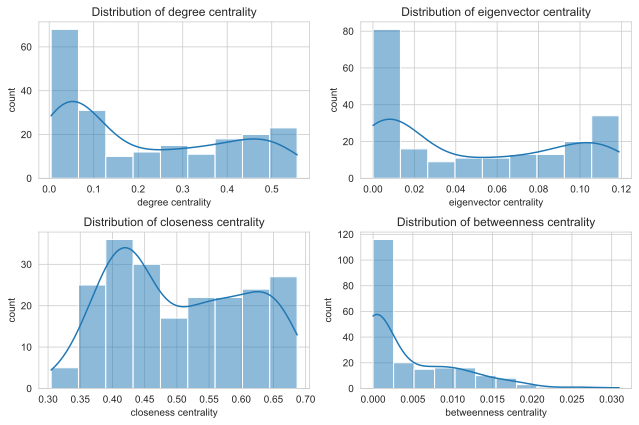

In [8]:
# plot distributions of centralities

sns.set_style("whitegrid")

# define plotting region (3 columns)
fig, axes = plt.subplots(2,2, figsize=(9,6)) 

#create boxplot in each subplot
fig1 = sns.histplot(data=node_features, x='degree_centrality', kde=True, ax=axes[0,0])
fig1.set(xlabel ="degree centrality", ylabel = "count", title ='Distribution of degree centrality')
fig2 = sns.histplot(data=node_features, x='eigenvector_centrality', kde = True, ax=axes[0,1])
fig2.set(xlabel ="eigenvector centrality", ylabel = "count", title ='Distribution of eigenvector centrality')
fig3 = sns.histplot(data=node_features, x='closeness_centrality', kde = True, ax=axes[1,0])
fig3.set(xlabel ="closeness centrality", ylabel = "count", title ='Distribution of closeness centrality')
fig4 = sns.histplot(data=node_features, x='betweenness_centrality', kde = True, ax=axes[1,1])
fig4.set(xlabel ="betweenness centrality", ylabel = "count", title ='Distribution of betweenness centrality')

plt.tight_layout() 

#plt.savefig("centralities.svg", bbox_inches='tight')

These histograms show the respective distributions of the centralities, where the blue line is a kernel density estimation (kde), which is supposed to smooth the distribution and thus make it more recognizable.

Overall, it can be seen that the value ranges of the centralities differ considerably between the 4 centralities. While the smallest values of degree centrality, eigenvector centrality and betweenness centrality are 0 or very close to 0, the smallest value of closeness centrality is slightly above 0.3. Furthermore, degree centrality and closeness centrality with values above 0.5 and slightly below 0.7, respectively, can have significantly higher values than eigenvector centrality with slightly below 0.12 and especially betweenness centrality with slightly above 0.02. 

We recognize that the distributions of degree centrality and eigenvector centrality are similar. Both have a high number of HCPs in the very bottom of the distribution near the value 0. There are significantly fewer HCPs in the middle region of the distribution for both distributions, while there are again significantly more HCPs in the upper region of the distribution for both centralities, but noticeably fewer than in the very lower region.

The distribution of closeness centrality differs from the distributions of degree centrality and eigenvector centrality in that there are very few HCPs in the very lower range, while most HCPs are in the lower middle and upper middle ranges. However, as with degree centrality and eigenvector centrality, there are significantly more HCPs in the very upper range.

The distribution of betweenness centrality is much more different from the distributions of closeness and eigenvector centrality. More than half of the HCPs are at the very bottom of the distribution, while the rest of the HCPs are relatively evenly distributed across the rest of the distribution, with fewer and fewer HCPs having higher and higher values.

## Assignment of influencer status

We now want to determine the importance of the individual HCPs in order to be able to perform an influencer determination.

In order to consider all 4 centralities equally in the influencer determination and account for their different value ranges, we choose the following procedure: We assign a rank for each of the 4 centralties `degree_centrality`, `eigenvector_centrality`, `closeness_centrality` and `betweenness centrality` to each of the 208 HCPs, resulting in the 4 new columns `degree_centrality_rank`, `eigenvector_centrality_rank`, `closeness_centrality_rank` and `betweenness_centrality_rank`. The motive is that a higher value of a centrality indicates a higher importance of the respective HCP in the respective context of the centrality. Thus, for each of the 4 centralities, a rank is assigned to the HCPs, where the HCP with the highest value of a centrality receives rank 1, while the HCP with the lowest value of a centrality receives rank 208. After each HCP has been assigned a rank for the 4 centralities, the average of the 4 ranks is calculated for each HCP and thus its final rank is determined, which is recorded in the new column `mean_rank`.

Based on this final rank `mean_rank`, an influencer status is assigned to each HCP according to one of 6 categories, and recorded in the new column `influencer_status`. 

The following table shows which influencer status is assigned to which respective quantile of the final rank `mean_rank`.

| Influencer status | Mean rank score |
| :--- | :---: |
| Mega influencer | top $2\%$ |
| Macro influencer | top $20\%$ |
| Mid-tier influencer | top $70\%$ |
| Micro influencer | top $90\%$ |
| Nano influencer | top $95\%$ |
| No influencer | below top $95\%$ |

We now perform the assignment of the respective influencer status.

At first, we compute the degree rank, degree centrality rank, eigenvector centrality rank, closeness centrality rank and betweenness centrality rank.

In [9]:
node_features['degree_rank'] = node_features['degree'].rank(ascending=False)
node_features['degree_centrality_rank'] = node_features['degree_centrality'].rank(ascending=False)
node_features['eigenvector_centrality_rank'] = node_features['eigenvector_centrality'].rank(ascending=False)
node_features['closeness_centrality_rank'] = node_features['closeness_centrality'].rank(ascending=False)
node_features['betweenness_centrality_rank'] = node_features['betweenness_centrality'].rank(ascending=False)
node_features

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,degree,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank
0,Adel Hamdalla,HCP,Doctor,SE-42-Onkologi,Avd E71 Hematologi onkologi,Södra Älvsborgs Sjukhus Borås,BC,T3,S3,0012o00002kTDKp,...,4,0.017544,0.003601,0.406417,0.000000,193.0,193.0,173.0,167.0,170.5
1,Aglaia Schiza,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Akademiska sjukhuset,BC,T3,S3,0012o00002kTBeA,...,85,0.372807,0.089436,0.586118,0.003605,60.0,60.0,59.0,59.5,82.0
2,Agneta Danfors,HCP,Doctor,SE-1J-Bröstonkologi,Drottningmottagningen,Drottningmottagningen,BC,T2,S2,0012o00002iEZxE,...,35,0.153509,0.040358,0.510067,0.000000,103.0,103.0,102.0,99.0,170.5
3,Ahmed Kareem,HCP,Doctor,SE-42-Onkologi,Onkologiska kliniken,Universitetssjukhuset Linköping,BC,T2,S2,0012o00002kTAKC,...,4,0.017544,0.001211,0.360759,0.000000,193.0,193.0,194.0,201.0,170.5
4,Alaa Haidar,HCP,Doctor,SE-42-Onkologi,Onkologiska enheten,Hallands sjukhus Halmstad,BC,T2,S2,0012o00002iDs1j,...,12,0.052632,0.011124,0.455090,0.000000,147.0,147.0,143.0,117.0,170.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Ylva Stenlund,HCP,Doctor,SE-42-Onkologi,Cancercentrum,Norrlands Universitetssjukhus,BC,T3,S3,0012o00002iEaBJ,...,19,0.083333,0.011180,0.432638,0.000000,126.5,126.5,138.5,138.0,170.5
204,Anna Nyberg,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,BC,T3,S3,0012o00002iEYHR,...,57,0.250000,0.054953,0.533958,0.006390,86.0,86.0,88.0,85.5,67.0
205,Göran Carlstedt,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Centrallasarettet Växjö,Melanoma,T2,S3,0012o00002iETYR,...,6,0.026316,0.001799,0.393782,0.000350,183.0,183.0,188.0,177.0,122.0
206,Mikael Wallander,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,Melanoma,T2,S3,0012o00002kT9l2,...,9,0.039474,0.004665,0.410811,0.000000,159.5,159.5,163.0,165.0,170.5


In [10]:
node_features['mean_rank'] = 0.25 * node_features['degree_centrality_rank'] \
                            + 0.25 * node_features['eigenvector_centrality_rank'] \
                            + 0.25 * node_features['closeness_centrality_rank'] \
                            + 0.25 * node_features['betweenness_centrality_rank']        
node_features

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,mean_rank
0,Adel Hamdalla,HCP,Doctor,SE-42-Onkologi,Avd E71 Hematologi onkologi,Södra Älvsborgs Sjukhus Borås,BC,T3,S3,0012o00002kTDKp,...,0.017544,0.003601,0.406417,0.000000,193.0,193.0,173.0,167.0,170.5,175.875
1,Aglaia Schiza,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Akademiska sjukhuset,BC,T3,S3,0012o00002kTBeA,...,0.372807,0.089436,0.586118,0.003605,60.0,60.0,59.0,59.5,82.0,65.125
2,Agneta Danfors,HCP,Doctor,SE-1J-Bröstonkologi,Drottningmottagningen,Drottningmottagningen,BC,T2,S2,0012o00002iEZxE,...,0.153509,0.040358,0.510067,0.000000,103.0,103.0,102.0,99.0,170.5,118.625
3,Ahmed Kareem,HCP,Doctor,SE-42-Onkologi,Onkologiska kliniken,Universitetssjukhuset Linköping,BC,T2,S2,0012o00002kTAKC,...,0.017544,0.001211,0.360759,0.000000,193.0,193.0,194.0,201.0,170.5,189.625
4,Alaa Haidar,HCP,Doctor,SE-42-Onkologi,Onkologiska enheten,Hallands sjukhus Halmstad,BC,T2,S2,0012o00002iDs1j,...,0.052632,0.011124,0.455090,0.000000,147.0,147.0,143.0,117.0,170.5,144.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Ylva Stenlund,HCP,Doctor,SE-42-Onkologi,Cancercentrum,Norrlands Universitetssjukhus,BC,T3,S3,0012o00002iEaBJ,...,0.083333,0.011180,0.432638,0.000000,126.5,126.5,138.5,138.0,170.5,143.375
204,Anna Nyberg,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,BC,T3,S3,0012o00002iEYHR,...,0.250000,0.054953,0.533958,0.006390,86.0,86.0,88.0,85.5,67.0,81.625
205,Göran Carlstedt,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Centrallasarettet Växjö,Melanoma,T2,S3,0012o00002iETYR,...,0.026316,0.001799,0.393782,0.000350,183.0,183.0,188.0,177.0,122.0,167.500
206,Mikael Wallander,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,Melanoma,T2,S3,0012o00002kT9l2,...,0.039474,0.004665,0.410811,0.000000,159.5,159.5,163.0,165.0,170.5,164.500


In [11]:
node_features.sort_values(by=['mean_rank'])

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,mean_rank
100,Per Karlsson,HCP,Doctor,SE-42-Onkologi,Per Karlsson Oncology Consulting,Sahlgrenska Univ sjh,BC,T1,S1,0012o00002kTDQh,...,0.557018,0.117721,0.686747,0.019889,1.0,1.0,3.0,1.0,5.0,2.500
106,Roger Henriksson,HCP,Doctor,SE-42-Onkologi,Vetenskapliga råd Läkemedel,Norrlands Universitetssjukhus,BC,T3,S3,0012o00002iEY4D,...,0.552632,0.116965,0.676558,0.021395,2.0,2.0,7.0,2.0,4.0,3.750
112,Tommy Fornander,HCP,Doctor,SE-42-Onkologi,Onkologenheten SÖS,Södersjukhuset,BC,T3,S3,0012o00002iER8M,...,0.539474,0.115661,0.674556,0.017318,5.0,5.0,10.0,3.5,10.0,7.125
101,Per Malmström,HCP,Doctor,SE-42-Onkologi,VO Hematologi Onkologi Strålningsfysik,Skånes Universitetssjukhus Lund,BC,T3,S3,0012o00002iERGt,...,0.530702,0.115102,0.670588,0.014843,9.0,9.0,12.0,8.0,16.0,11.250
36,Yvonne Wengström,HCP,Nurse,SE-42-Onkologi,ME Huvud- hals- lung- och hudcancer,Karolinska Univ Sjh Solna,BC,T4,S4,0012o00002iEdnj,...,0.543860,0.118599,0.674556,0.009648,3.0,3.0,2.0,3.5,43.0,12.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Pär Bodén,HCP,Doctor,SE-42-Onkologi,Onkologmottagning,Östersunds Sjukhus,BC,T2,S2,0012o00002iEc7V,...,0.013158,0.000071,0.304813,0.000000,198.5,198.5,207.5,207.0,170.5,195.875
124,Sandra Cedervall,HCP,Nurse,SE-42-Onkologi,Onkologmottagning,Östersunds Sjukhus,BC,T3,S3,0012o00002iEeGA,...,0.013158,0.000071,0.304813,0.000000,198.5,198.5,207.5,207.0,170.5,195.875
75,Lena Tennvall,HCP,Doctor,SE-42-Onkologi,VO Onkologi och Strålningsfysik,Skånes Universitetssjukhus Malmö,BC,T3,S3,0012o00002kTC9H,...,0.004386,0.000516,0.335788,0.000000,206.5,206.5,204.0,204.0,170.5,196.250
81,Gudrun Linderkers,HCP,Nurse,SE-42-Onkologi,Onkologmottagningen,Falu Lasarett,BC,T4,S4,0012o00002kTEV0,...,0.008772,0.000077,0.304813,0.000000,202.5,202.5,206.0,207.0,170.5,196.500


In the next step, we create an influencer status variable.

In [12]:
node_features['influencer_status'] = node_features.apply(get_influencer_status, axis=1)
node_features

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,mean_rank,influencer_status
0,Adel Hamdalla,HCP,Doctor,SE-42-Onkologi,Avd E71 Hematologi onkologi,Södra Älvsborgs Sjukhus Borås,BC,T3,S3,0012o00002kTDKp,...,0.003601,0.406417,0.000000,193.0,193.0,173.0,167.0,170.5,175.875,micro
1,Aglaia Schiza,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Akademiska sjukhuset,BC,T3,S3,0012o00002kTBeA,...,0.089436,0.586118,0.003605,60.0,60.0,59.0,59.5,82.0,65.125,mid-tier
2,Agneta Danfors,HCP,Doctor,SE-1J-Bröstonkologi,Drottningmottagningen,Drottningmottagningen,BC,T2,S2,0012o00002iEZxE,...,0.040358,0.510067,0.000000,103.0,103.0,102.0,99.0,170.5,118.625,mid-tier
3,Ahmed Kareem,HCP,Doctor,SE-42-Onkologi,Onkologiska kliniken,Universitetssjukhuset Linköping,BC,T2,S2,0012o00002kTAKC,...,0.001211,0.360759,0.000000,193.0,193.0,194.0,201.0,170.5,189.625,nano
4,Alaa Haidar,HCP,Doctor,SE-42-Onkologi,Onkologiska enheten,Hallands sjukhus Halmstad,BC,T2,S2,0012o00002iDs1j,...,0.011124,0.455090,0.000000,147.0,147.0,143.0,117.0,170.5,144.375,mid-tier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Ylva Stenlund,HCP,Doctor,SE-42-Onkologi,Cancercentrum,Norrlands Universitetssjukhus,BC,T3,S3,0012o00002iEaBJ,...,0.011180,0.432638,0.000000,126.5,126.5,138.5,138.0,170.5,143.375,mid-tier
204,Anna Nyberg,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,BC,T3,S3,0012o00002iEYHR,...,0.054953,0.533958,0.006390,86.0,86.0,88.0,85.5,67.0,81.625,mid-tier
205,Göran Carlstedt,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Centrallasarettet Växjö,Melanoma,T2,S3,0012o00002iETYR,...,0.001799,0.393782,0.000350,183.0,183.0,188.0,177.0,122.0,167.500,micro
206,Mikael Wallander,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,Melanoma,T2,S3,0012o00002kT9l2,...,0.004665,0.410811,0.000000,159.5,159.5,163.0,165.0,170.5,164.500,micro


For the next plot, we calculate the respective quantiles of `mean_rank`.

In [13]:
max_rank = node_features['mean_rank'].max()
q_2 = node_features['mean_rank'].quantile(.02)
q_20 = node_features['mean_rank'].quantile(.2)
q_70 = node_features['mean_rank'].quantile(.7)
q_90 = node_features['mean_rank'].quantile(.9)
q_95 = node_features['mean_rank'].quantile(.95)
min_rank = node_features['mean_rank'].min()

Let us now take a look at the distribution of `mean_rank`, both with pre-defined binwidth and bins corresponding to influencer status.

Note that we add a very small value, 0.001, to the quantiles usef for the right plot to make sure that bars in the plot correctly show the sizes of the influencer groups. 

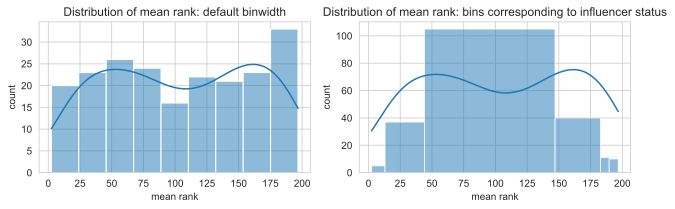

In [14]:
# plot distribution of mean rank

sns.set_style("whitegrid") 

# define plotting region (2 columns)
fig, axes = plt.subplots(1, 2, figsize=(9,3)) 

#create boxplot in each subplot
fig5 = sns.histplot(data=node_features, x="mean_rank", kde=True, ax=axes[0])
fig5.set(xlabel ="mean rank", ylabel = "count", title ='Distribution of mean rank: default binwidth')
fig6 = sns.histplot(data=node_features, x="mean_rank", bins=[min_rank, q_2+0.001, q_20+0.001, q_70+0.001, q_90+0.001, q_95+0.001, max_rank], kde=True, ax=axes[1])
fig6.set(xlabel ="mean rank", ylabel = "count", title ='Distribution of mean rank: bins corresponding to influencer status')

plt.tight_layout()

#plt.savefig("histograms_mean_rank.svg", bbox_inches='tight')

In [15]:
node_features[['mean_rank']].describe()

,mean_rank
count,208.00000
mean,104.50000
std,57.99863
min,2.50000
25%,52.00000
50%,106.25000
75%,155.87500
max,196.75000


Note that here a lower mean rank of an HCP means that he is more important in the network and has a higher influencer status.

In the figure on the left, a distribution can be observed for the mean rank that is much more similar to a uniform distribution than is the case with the distributions of the centralities. This is evident from the fact that the bars generally have a similar height and the kernel density estimation does not show such strong fluctuations as in the case of the distributions of the centralities.

However, in the kernel density estimation we recognize two peaks around 50 and 160. A dip is present at about 110. 

The figure on the right reflects our assignment of HCPs to influencer groups. The mid-tier influencer group is by far the largest, followed by the macro influencer group and the micro influencer group, which are roughly the same size. The mega influencer group, nano influencer group and no influencer group are by far the smallest.

## Analysis of influencer groups

Let us now take a look in detail at the 6 influencer groups and compile some summary statistics for them.

### Mega influencers

Mega influencers have a mean rank that is among the highest 2% of all mean ranks.

In [16]:
node_features[node_features['influencer_status'] == 'mega']

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,mean_rank,influencer_status
36,Yvonne Wengström,HCP,Nurse,SE-42-Onkologi,ME Huvud- hals- lung- och hudcancer,Karolinska Univ Sjh Solna,BC,T4,S4,0012o00002iEdnj,...,0.118599,0.674556,0.009648,3.0,3.0,2.0,3.5,43.0,12.875,mega
100,Per Karlsson,HCP,Doctor,SE-42-Onkologi,Per Karlsson Oncology Consulting,Sahlgrenska Univ sjh,BC,T1,S1,0012o00002kTDQh,...,0.117721,0.686747,0.019889,1.0,1.0,3.0,1.0,5.0,2.500,mega
101,Per Malmström,HCP,Doctor,SE-42-Onkologi,VO Hematologi Onkologi Strålningsfysik,Skånes Universitetssjukhus Lund,BC,T3,S3,0012o00002iERGt,...,0.115102,0.670588,0.014843,9.0,9.0,12.0,8.0,16.0,11.250,mega
106,Roger Henriksson,HCP,Doctor,SE-42-Onkologi,Vetenskapliga råd Läkemedel,Norrlands Universitetssjukhus,BC,T3,S3,0012o00002iEY4D,...,0.116965,0.676558,0.021395,2.0,2.0,7.0,2.0,4.0,3.750,mega
112,Tommy Fornander,HCP,Doctor,SE-42-Onkologi,Onkologenheten SÖS,Södersjukhuset,BC,T3,S3,0012o00002iER8M,...,0.115661,0.674556,0.017318,5.0,5.0,10.0,3.5,10.0,7.125,mega


In [17]:
get_influencer_summary('mega')

Number of influencers: 5 
-------------------------- 
Of which doctors: 4 
Of which nurses: 1 
-------------------------- 
Of which BC: 5 
Of which melanoma: 0 
--------------------------


In [18]:
5/208

0.02403846153846154

### Macro influencers

Macro influencers have a mean rank that is among the highest 20% percent of all mean ranks but below the highest 2% of all mean ranks.

In [19]:
node_features[node_features['influencer_status'] == 'macro']

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,mean_rank,influencer_status
11,Anna Nordenskjöld,HCP,Doctor,SE-42-Onkologi,Medicin- och onkologkliniken,Södra Älvsborgs Sjukhus Borås,BC,T3,S3,0012o00002iET3R,...,0.108689,0.640449,0.013355,32.5,32.5,29.0,30.5,21.0,28.250,macro
19,Barbro Linderholm,HCP,Doctor,SE-42-Onkologi,VO Onkologi,Sahlgrenska Univ sjh,BC,T1,S1,0012o00002iETcV,...,0.109032,0.657061,0.019201,25.0,25.0,28.0,22.0,6.0,20.250,macro
22,Maria Sandström,HCP,Nurse,SE-42-Onkologi,Cancercentrum,Norrlands Universitetssjukhus,BC,T4,S4,0012o00002kTqXC,...,0.095500,0.612903,0.012989,41.5,41.5,48.0,44.5,25.0,39.750,macro
24,Cecilia Nilsson,HCP,Doctor,SE-42-Onkologi,Onkologikliniken,Västmanlands sjukhus Västerås,BC,T2,S2,0012o00002iEZpE,...,0.111258,0.658960,0.018211,21.5,21.5,22.0,19.5,7.0,17.500,macro
32,Dan Lundstedt,HCP,Doctor,SE-42-Onkologi,VO Onkologi,Sahlgrenska Univ sjh,BC,T3,S3,0012o00002iEPTk,...,0.103834,0.631579,0.007425,35.0,35.0,37.0,34.0,60.0,41.500,macro
37,Elisabet Lidbrink,HCP,Doctor,SE-1J-Bröstonkologi,Bröstcentrum,Karolinska Univ Sjh Solna,BC,T3,S3,0012o00002kT9zd,...,0.108235,0.640449,0.005349,30.5,30.5,30.0,30.5,72.0,40.750,macro
48,Greger Nilsson,HCP,Doctor,SE-42-Onkologi,Onkologenheten,Visby lasarett,BC,T2,S2,0012o00002kTCqX,...,0.106110,0.629834,0.011321,38.0,38.0,34.0,36.5,30.0,34.625,macro
53,Henrik Lindman,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Akademiska sjukhuset,BC,T1,S1,0012o00002kTAh5,...,0.114162,0.658960,0.008543,19.0,19.0,13.0,19.5,51.0,25.625,macro
56,Jan Frisell,HCP,Doctor,SE-11-Kirurgi,Bröstcentrum,Karolinska Univ Sjh Solna,BC,T1,S1,0012o00002kTE4Y,...,0.118865,0.672566,0.007693,5.0,5.0,1.0,6.0,58.0,17.500,macro
57,Jenny Bergqvist,HCP,Doctor,SE-42-Onkologi,Kirurgkliniken,Capio S:t Görans Sjukhus AB,BC,T2,S2,0012o00002iEepp,...,0.107636,0.645892,0.016702,32.5,32.5,31.0,26.0,12.0,25.375,macro


In [20]:
get_influencer_summary('macro')

Number of influencers: 37 
-------------------------- 
Of which doctors: 35 
Of which nurses: 2 
-------------------------- 
Of which BC: 31 
Of which melanoma: 6 
--------------------------


In [21]:
42/208

0.20192307692307693

### Mid-tier influencers

Mid-tier influencers have a mean rank that is among the highest 70% percent of all mean ranks but below the highest 20% of all mean ranks.

In [22]:
node_features[node_features['influencer_status'] == 'mid-tier']

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,mean_rank,influencer_status
1,Aglaia Schiza,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Akademiska sjukhuset,BC,T3,S3,0012o00002kTBeA,...,0.089436,0.586118,0.003605,60.0,60.0,59.0,59.5,82.0,65.125,mid-tier
2,Agneta Danfors,HCP,Doctor,SE-1J-Bröstonkologi,Drottningmottagningen,Drottningmottagningen,BC,T2,S2,0012o00002iEZxE,...,0.040358,0.510067,0.000000,103.0,103.0,102.0,99.0,170.5,118.625,mid-tier
4,Alaa Haidar,HCP,Doctor,SE-42-Onkologi,Onkologiska enheten,Hallands sjukhus Halmstad,BC,T2,S2,0012o00002iDs1j,...,0.011124,0.455090,0.000000,147.0,147.0,143.0,117.0,170.5,144.375,mid-tier
5,Ana Campos,HCP,Doctor,SE-99-Övrig,Sekt V Onkologi och patologi MV,Lunds Universitet,BC,T2,S2,0012o00002kTn92,...,0.034760,0.475000,0.000030,109.0,109.0,104.0,112.0,132.0,114.250,mid-tier
6,Andreas Nearchou,HCP,Doctor,SE-42-Onkologi,Onkologkliniken Sörmland,Mälarsjukhuset,BC,T2,S2,0012o00002iEcW0,...,0.094636,0.592208,0.010508,57.0,57.0,52.0,56.5,39.0,51.125,mid-tier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Olof Bjarnadottir,HCP,Doctor,SE-42-Onkologi,nan,Lunds Universitet,BC,T3,S3,0012o00002iER0W,...,0.033484,0.490323,0.000161,107.5,107.5,106.0,103.0,127.0,110.875,mid-tier
200,Sara Kinhult,HCP,Doctor,SE-42-Onkologi,VO Hematologi Onkologi Strålningsfysik,Skånes Universitetssjukhus Lund,BC,T3,S3,0012o00002iEcCc,...,0.097033,0.609626,0.005974,48.0,48.0,46.0,47.0,68.0,52.250,mid-tier
203,Ylva Stenlund,HCP,Doctor,SE-42-Onkologi,Cancercentrum,Norrlands Universitetssjukhus,BC,T3,S3,0012o00002iEaBJ,...,0.011180,0.432638,0.000000,126.5,126.5,138.5,138.0,170.5,143.375,mid-tier
204,Anna Nyberg,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,BC,T3,S3,0012o00002iEYHR,...,0.054953,0.533958,0.006390,86.0,86.0,88.0,85.5,67.0,81.625,mid-tier


In [23]:
get_influencer_summary('mid-tier')

Number of influencers: 105 
-------------------------- 
Of which doctors: 75 
Of which nurses: 30 
-------------------------- 
Of which BC: 67 
Of which melanoma: 38 
--------------------------


In [24]:
147/208

0.7067307692307693

### Micro influencers

Micro influencers have a mean rank that is among the highest 90% percent of all mean ranks but below the highest 70% of all mean ranks.

In [25]:
node_features[node_features['influencer_status'] == 'micro']

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,mean_rank,influencer_status
0,Adel Hamdalla,HCP,Doctor,SE-42-Onkologi,Avd E71 Hematologi onkologi,Södra Älvsborgs Sjukhus Borås,BC,T3,S3,0012o00002kTDKp,...,0.003601,0.406417,0.000000,193.0,193.0,173.0,167.0,170.5,175.875,micro
9,Elisabeth Ausén,HCP,Nurse,SE-11-Kirurgi,Bröstcentrum,Capio S:t Görans Sjukhus AB,BC,T4,S4,0012o00002iEVPo,...,0.006915,0.415301,0.000000,150.5,150.5,153.0,160.0,170.5,158.500,micro
33,Dawid Bulanda,HCP,Doctor,SE-42-Onkologi,Onkologienheten,Länssjukhuset i Kalmar,BC,T3,S3,0012o00002iETrT,...,0.004451,0.398601,0.000000,155.5,155.5,166.5,174.5,170.5,166.750,micro
38,Elzbieta Dziedzic,HCP,Doctor,SE-42-Onkologi,Onkologienheten,Länssjukhuset i Kalmar,BC,T3,S3,0012o00002kTliQ,...,0.004451,0.398601,0.000000,155.5,155.5,166.5,174.5,170.5,166.750,micro
40,Ann Nilsson,HCP,Nurse,SE-42-Onkologi,Onkologenheten,Visby lasarett,BC,T4,S4,0012o00002iEYWG,...,0.002458,0.388416,0.000000,198.5,198.5,181.5,180.5,170.5,182.750,micro
45,Gerhard Winblad,HCP,Doctor,SE-42-Onkologi,Onkologenheten SÖS,Södersjukhuset,BC,T3,S3,0012o00002iERzI,...,0.005207,0.416058,0.000000,173.5,173.5,159.0,157.0,170.5,165.000,micro
50,Marika Hjelmqvist,HCP,Nurse,SE-42-Onkologi,Onkologenheten SÖS,Södersjukhuset,BC,T4,S4,0012o00002iEfIz,...,0.005207,0.416058,0.000000,173.5,173.5,159.0,157.0,170.5,165.000,micro
52,Anna Askelin,HCP,Nurse,SE-42-Onkologi,Onkologienheten,Länssjukhuset i Kalmar,BC,T4,S4,0012o00002kTCYp,...,0.004451,0.398601,0.000000,155.5,155.5,166.5,174.5,170.5,166.750,micro
54,Ida Rosén,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Länssjukhuset Ryhov,BC,T3,S3,0012o00002kTEOj,...,0.004665,0.410811,0.000000,159.5,159.5,163.0,165.0,170.5,164.500,micro
65,Katalin Kovacs,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Gävle Sjukhus,BC,T3,S3,0012o00002kTDlx,...,0.003355,0.387097,0.000000,173.5,173.5,177.0,183.0,170.5,176.000,micro


In [26]:
get_influencer_summary('micro')

Number of influencers: 40 
-------------------------- 
Of which doctors: 22 
Of which nurses: 18 
-------------------------- 
Of which BC: 24 
Of which melanoma: 16 
--------------------------


In [27]:
187/208

0.8990384615384616

### Nano influencers

Nano influencers have a mean rank that is among the highest 95% percent of all mean ranks but below the highest 90% of all mean ranks.

In [28]:
node_features[node_features['influencer_status'] == 'nano']

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,mean_rank,influencer_status
3,Ahmed Kareem,HCP,Doctor,SE-42-Onkologi,Onkologiska kliniken,Universitetssjukhuset Linköping,BC,T2,S2,0012o00002kTAKC,...,0.001211,0.360759,0.0,193.0,193.0,194.0,201.0,170.5,189.625,nano
15,Anna Häll,HCP,Nurse,SE-42-Onkologi,Aleris Christinakliniken,Sophiahemmet AB,BC,T4,S4,0012o00002iEQSf,...,0.001498,0.389078,0.0,202.5,202.5,191.0,179.0,170.5,185.750,nano
69,Susanne Söder,HCP,Nurse,SE-42-Onkologi,Onkologkliniken,Länssjh Sundsvall-Härnösand,BC,T4,S4,0012o00002iEW7A,...,0.001615,0.378109,0.0,187.0,187.0,189.5,187.5,170.5,183.625,nano
78,Malgorzata Lula,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Centrallasarettet Växjö,BC,T3,S3,0012o00002iEewk,...,0.000953,0.367150,0.0,187.0,187.0,198.0,195.0,170.5,187.625,nano
82,Karin Maltenius,HCP,Nurse,SE-42-Onkologi,Onkologmottagningen,Centrallasarettet Växjö,BC,NT,S4,0012o00002kTDmj,...,0.000953,0.367150,0.0,187.0,187.0,198.0,195.0,170.5,187.625,nano
94,Nina Ayoubi,HCP,Doctor,SE-42-Onkologi,Onkologiska kliniken,Universitetssjukhuset Linköping,BC,T3,S3,0012o00002kTmDf,...,0.001211,0.360759,0.0,193.0,193.0,194.0,201.0,170.5,189.625,nano
108,Sigrid Karstorp,HCP,Doctor,SE-42-Onkologi,Kirurgens onkologimottagning 61,Skaraborgs Sjukhus Skövde,BC,T3,S3,0012o00002kTDBK,...,0.001816,0.399299,0.0,202.5,202.5,187.0,172.0,170.5,183.000,nano
114,Ulrika Palenius,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Centrallasarettet Växjö,BC,T3,S3,0012o00002iEUrq,...,0.000953,0.367150,0.0,187.0,187.0,198.0,195.0,170.5,187.625,nano
125,Anneli Fahlen,HCP,Nurse,SE-42-Onkologi,Onkologkliniken,Länssjh Sundsvall-Härnösand,BC,T3,S3,0012o00002kTo5W,...,0.001615,0.378109,0.0,187.0,187.0,189.5,187.5,170.5,183.625,nano
150,Jan Rzepecki,HCP,Doctor,SE-42-Onkologi,Onkologiska kliniken,Universitetssjukhuset Linköping,Melanoma,T2,S2,0012o00002iEdjo,...,0.001211,0.360759,0.0,193.0,193.0,194.0,201.0,170.5,189.625,nano


In [29]:
get_influencer_summary('nano')

Number of influencers: 11 
-------------------------- 
Of which doctors: 6 
Of which nurses: 5 
-------------------------- 
Of which BC: 10 
Of which melanoma: 1 
--------------------------


In [30]:
198/208

0.9519230769230769

### No influencers

No influencers have a mean rank that is below the highest 95% of all mean ranks.

In [31]:
node_features[node_features['influencer_status'] == 'no']

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,mean_rank,influencer_status
7,Ulrika Bergqvist,HCP,Nurse,SE-11-Kirurgi,Avd 8 Kirurg- ortopedi,Skellefteå Lasarett,BC,T4,S4,0012o00002iEdBr,...,0.001051,0.372549,0.0,206.5,206.5,196.0,193.0,170.5,191.500,no
10,Marie Santonsson,HCP,Nurse,SE-11-Kirurgi,Kirurg och Urologmottagningen,Blekingesjukhuset i Karlskrona,BC,NT,S4,0012o00002iEcUJ,...,0.000934,0.361331,0.0,193.0,193.0,202.0,198.0,170.5,190.875,no
29,Malin Steenhoff,HCP,Nurse,SE-42-Onkologi,Kirurgklinikens onkologiska dagvård,Blekingesjukhuset i Karlskrona,BC,NT,S4,0012o00002kTl6q,...,0.000934,0.361331,0.0,193.0,193.0,200.5,198.0,170.5,190.500,no
30,Therése Widerberg,HCP,Nurse,SE-42-Onkologi,Kirurgklinikens onkologiska dagvård,Blekingesjukhuset i Karlskrona,BC,NT,S4,0012o00002iES8m,...,0.000934,0.361331,0.0,193.0,193.0,200.5,198.0,170.5,190.500,no
49,Gunnar Lengstrand,HCP,Doctor,SE-42-Onkologi,Onkologenheten,Uddevalla sjukhus,BC,T2,S2,0012o00002iEWUb,...,0.000800,0.354037,0.0,202.5,202.5,203.0,203.0,170.5,194.750,no
75,Lena Tennvall,HCP,Doctor,SE-42-Onkologi,VO Onkologi och Strålningsfysik,Skånes Universitetssjukhus Malmö,BC,T3,S3,0012o00002kTC9H,...,0.000516,0.335788,0.0,206.5,206.5,204.0,204.0,170.5,196.250,no
81,Gudrun Linderkers,HCP,Nurse,SE-42-Onkologi,Onkologmottagningen,Falu Lasarett,BC,T4,S4,0012o00002kTEV0,...,0.000077,0.304813,0.0,202.5,202.5,206.0,207.0,170.5,196.500,no
86,Karin Jannesson,HCP,Nurse,SE-42-Onkologi,Onkologomottagning,Skaraborgs Sjh Lidköping,BC,NT,S4,0012o00002kTAsS,...,0.000328,0.325714,0.0,206.5,206.5,205.0,205.0,170.5,196.750,no
95,Pär Bodén,HCP,Doctor,SE-42-Onkologi,Onkologmottagning,Östersunds Sjukhus,BC,T2,S2,0012o00002iEc7V,...,0.000071,0.304813,0.0,198.5,198.5,207.5,207.0,170.5,195.875,no
124,Sandra Cedervall,HCP,Nurse,SE-42-Onkologi,Onkologmottagning,Östersunds Sjukhus,BC,T3,S3,0012o00002iEeGA,...,0.000071,0.304813,0.0,198.5,198.5,207.5,207.0,170.5,195.875,no


In [32]:
get_influencer_summary('no')

Number of influencers: 10 
-------------------------- 
Of which doctors: 3 
Of which nurses: 7 
-------------------------- 
Of which BC: 10 
Of which melanoma: 0 
--------------------------


In [33]:
208/208

1.0

In [34]:
print(node_features.groupby('account_type')['account_type'].count(), '\n')
print(node_features.groupby('indication')['indication'].count())

account_type
Doctor    145
Nurse      63
Name: account_type, dtype: int64 

indication
BC          147
Melanoma     61
Name: indication, dtype: int64


Finally, we report the overview with influencer status, "theoretical" score `mean_rank` and true score `mean_rank` since the true percentages can deviate, total, together with data on how the total is distributed over the values of account type (Doctor, Nurse) and indication (BC, Melanoma).

| Influencer status | Mean rank score | True mean rank score | Total | Doctor | Nurse | BC | Melamoma |
| :--- | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| Mega influencer | top $2\%$ | top $2.4038\%$ | 5 | 4 | 1 | 5 | 0 |
| Macro influencer | top $20\%$ | top $20.1923\%$ | 37 | 35 | 2 | 31 | 6 |
| Mid-tier influencer | top $70\%$ | top $70.6731\%$ | 105 | 75 | 30 | 67 | 38 |
| Micro influencer | top $90\%$ | top $89.9038\%$ | 40 | 22 | 18 | 24 | 16 |
| Nano influencer | top $95\%$ | top $95.1923\%$ | 11 | 6 | 5 | 10 | 1 |
| No influencer | below top $95\%$ | below top $95.1923\%$ | 10 | 3 | 7 | 10 | 0 |

We can see that the quantiles in score mean rank used to classify HCPs into influencer groups differ slightly from the resulting quantiles in true score mean rank. The reason for this is that 208 is not divisible by 100 without a remainder. 

Of the 208 HCPs, 145 are doctor and 63 are nurse, while 147 are BC HCPs and 61 are melanoma HCPs.

With regard to the variable **account type**, it is noticeable that the ratio of doctors to nurses is particularly high among the mega influencers and the macro influencers compared with the overall ratio of doctors and nurses. 
Among the mid-tier influencers, doctors and nurses are represented in roughly the same proportion as overall. Among micro influencers, nano influencers and no influencers, the ratio of doctor to nurse is small compared to the overall ratio of doctors and nurses. In these three groups, nurses are therefore overrepresented.

Overall, it can be seen that doctors dominate mega influencers and macro influencers, while nurses dominate micro influencers, nano influencers and no influencers. Among the mid-tier influencers, both are represented in roughly equal proportions. This finding is not surprising: doctors are much more involved in research and therefore usually have a much larger network than nurses, which makes them significantly more influential. (nurses study in Sweden)

Concerning the variable **indication**, we observe that the ratio of melanoma HCPs to BC HCPs is much smaller than the overall ratio of melanoma HCPs to BC HCPs for both mega influencers and macro influencers and for nano influencers and no influencers. The mega influencers and no influencers do not include a single melanoma HCP. However, among mid-tier influencers and micro influencers, melanoma HCPs are overrepresented compared with the overall ratio of melanoma HCPs to BC HCPs. 

Overall, therefore, the particularly influential and the particularly weakly influential HCPs belong almost exclusively to the BC HCPs, while the melanoma HCPs dominate the mid-tier and micro influencers in proportion. The reason that melanoma HCPs do not occur at all among mega influencers and only rarely among macro influencers could be that among our 208 different HCPs there are less than half as many melanoma HCPs as BC HCPs. Because melanoma HCPs are naturally more likely to form connections with other melanoma HCPs in the graph than with BC HCPs, the number of possible connections for melanoma HCPs is significantly smaller than for BC HCPs, which tends to make it more difficult for them than for BC HCPs to take an influential role in the graph.

## Recommendation of top 5 BC influencers and top 5 melanoma influencers

We will now determine the top 5 BC influencers and top 5 melanoma influencers. 

In [35]:
top_five_bc = get_top_five_influencers('BC')

The top five BC influencers are: 

1. Per Karlsson 
2. Roger Henriksson 
3. Tommy Fornander 
4. Per Malmström 
5. Yvonne Wengström


In [36]:
top_five_bc

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,mean_rank,influencer_status
100,Per Karlsson,HCP,Doctor,SE-42-Onkologi,Per Karlsson Oncology Consulting,Sahlgrenska Univ sjh,BC,T1,S1,0012o00002kTDQh,...,0.117721,0.686747,0.019889,1.0,1.0,3.0,1.0,5.0,2.500,mega
106,Roger Henriksson,HCP,Doctor,SE-42-Onkologi,Vetenskapliga råd Läkemedel,Norrlands Universitetssjukhus,BC,T3,S3,0012o00002iEY4D,...,0.116965,0.676558,0.021395,2.0,2.0,7.0,2.0,4.0,3.750,mega
112,Tommy Fornander,HCP,Doctor,SE-42-Onkologi,Onkologenheten SÖS,Södersjukhuset,BC,T3,S3,0012o00002iER8M,...,0.115661,0.674556,0.017318,5.0,5.0,10.0,3.5,10.0,7.125,mega
101,Per Malmström,HCP,Doctor,SE-42-Onkologi,VO Hematologi Onkologi Strålningsfysik,Skånes Universitetssjukhus Lund,BC,T3,S3,0012o00002iERGt,...,0.115102,0.670588,0.014843,9.0,9.0,12.0,8.0,16.0,11.250,mega
36,Yvonne Wengström,HCP,Nurse,SE-42-Onkologi,ME Huvud- hals- lung- och hudcancer,Karolinska Univ Sjh Solna,BC,T4,S4,0012o00002iEdnj,...,0.118599,0.674556,0.009648,3.0,3.0,2.0,3.5,43.0,12.875,mega


In [37]:
top_five_me = get_top_five_influencers('Melanoma')

The top five Melanoma influencers are: 

1. Gustav Ullenhag 
2. Hildur Helgadottir 
3. Lars Ny 
4. Max Levin 
5. Karin Johansson


In [38]:
top_five_me

,account_name,account_record_type,account_type,primary_specialty,primary_parent_name,top_account_name,indication,tier,segment,account_id,...,eigenvector_centrality,closeness_centrality,betweenness_centrality,degree_rank,degree_centrality_rank,eigenvector_centrality_rank,closeness_centrality_rank,betweenness_centrality_rank,mean_rank,influencer_status
128,Gustav Ullenhag,HCP,Doctor,SE-42-Onkologi,Onkologkliniken,Akademiska sjukhuset,Melanoma,ST,S1,0012o00002kTBYO,...,0.117109,0.666667,0.011068,9.0,9.0,6.0,10.0,32.0,14.250,macro
127,Hildur Helgadottir,HCP,Doctor,SE-42-Onkologi,ME Huvud- hals- lung- och hudcancer,Karolinska Univ Sjh Solna,Melanoma,T1,S1,0012o00002iESmB,...,0.113554,0.658960,0.017099,16.0,16.0,18.0,19.5,11.0,16.125,macro
190,Lars Ny,HCP,Doctor,SE-42-Onkologi,VO Onkologi,Sahlgrenska Univ sjh,Melanoma,ST,S1,0012o00002iEPVv,...,0.112802,0.658960,0.012662,16.0,16.0,19.0,19.5,27.0,20.375,macro
145,Max Levin,HCP,Doctor,SE-42-Onkologi,VO Onkologi,Sahlgrenska Univ sjh,Melanoma,T2,S3,0012o00002iEa5e,...,0.111669,0.645892,0.008782,21.5,21.5,21.0,26.0,49.0,29.375,macro
183,Karin Johansson,HCP,Nurse,SE-42-Onkologi,Med behandlingsenhet onkologi,Universitetssjukhuset Örebro,Melanoma,T2,S4,0012o00002iESxh,...,0.103743,0.626374,0.011627,41.5,41.5,38.0,39.0,29.0,36.875,macro


The top 5 BC influencers are:

* Per Karlsson
* Roger Henriksson
* Tommy Fornander
* Per Malmström
* Yvonne Wengström

All of them are mega influencers.

The top 5 melanoma influencers are:

* Gustav Ullenhag 
* Hildur Helgadottir 
* Lars Ny 
* Max Levin 
* Karin Johansson

All of them are macro influencers.

Novartis should specifically target these 10 HCPs because they are outstandingly influential and therefore promise to boost prescription and sales of Novartis drugs.

Not only are these 10 HCPs well-connected, as indicated by their degree centrality, but they also have a broad network through their one-hop neighbors (eigenvector centrality). Furthermore, their importance is also due to the fact that they often lie on the shortest paths between two nodes in the graph (closeness centrality) and also serve as bridges between nodes (betweenness centrality).

At the end of this notebook, we also calculate some summary statistics briefly mentioned in the thesis.

In [39]:
# calculate average degrees for segments
node_features.groupby('segment').mean()[['degree']]

,degree
segment,
S1,103.562500
S2,62.413043
S3,51.321429
S4,24.580645


In [40]:
# calculate correlation of segment and tier
np.corrcoef(LabelEncoder().fit_transform(node_features['segment']), LabelEncoder().fit_transform(node_features['tier']))

array([[1.       , 0.2468202],
       [0.2468202, 1.       ]])